# Final Exam

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Time
* You have 180 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Submission
* You will upload your solution to the Final Exam assignment on Canvas.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:

#### Section 2
* New file: `select_maturities_2017-02-07.xlsx`

#### Section 3
* Familiar file: `famabliss_strips_2023-12-29.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 25     |
| 2       | 45     |
| 3       | 60     |
| 4       | 35     |
| **Total**   | **165**|

***

# 1. Long-Short Trades

Consider the following market data as of `Dec 29, 2023`.

The table below shows two Treasury securities, a T-note and a T-bond. They mature on the same date.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Help_Functions as hf

summary = pd.DataFrame(index=[],columns = [207391,204095],dtype=float)
summary.loc['issue date'] = ['2019-08-15','1999-08-15']
summary.loc['maturity date'] = ['2029-08-15','2029-08-15']
summary.loc['coupon rate'] = [.01625, .06125]
summary.loc['clean price'] = [89.03125,111.0391]
summary.loc['accrued interest'] = [.6005, 2.2636]
summary.loc['ytm'] = [.037677, .038784]
summary.loc['duration'] = [5.3494,4.7967]
summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967


### 1.1. (5pts)

Explain the long-short trade you would enter based on the market data above, without any further calculation. 

*Answer :* Giving that both bonds have the same maturity, but different YTM, this could indicate a trade opportunity. In which we should take a long position on the bong with the higher YTM (``204095`` , YTM = 3.8784\%) and a short position on the bond with the lowerest YTM (``207391`` , YTM = 3.7577\%). Both should pay coupons at the same time (every 6m), with the long position we should recieved 6.125/2 and for the short position we should pay 1.625/2.

### 1.2. (5pts)

Size your trade.
* Suppose the long side is set to $100 million market value. 
* Size the short to be duration-neutral.

Report the market value in the short-side of the trade and the number of long and short contracts.

In [2]:
Long_position = 100e6
long_key = summary.loc['ytm'].astype('float64').idxmax()
short_key = summary.loc['ytm'].astype('float64').idxmin()

summary.loc['dirty price'] = summary.loc["clean price"] + summary.loc["accrued interest"]
summary.loc['modified duration'] = summary.loc['duration'] / (1 + summary.loc['ytm']/2)
hedge_result, hedge_ratio = hf.calculate_hedge_position(summary, long_key, short_key, long_position=Long_position, leverage=1)

In [3]:
print(f"Hedge Ratio - Dollar duration ratio: {hedge_ratio:.2f}")
display(hedge_result[["Dollar_Duration", "dirty price","Assets", "Contracts"]].dropna().style.format("{:,.2f}"))

Hedge Ratio - Dollar duration ratio: -1.13


,Dollar_Duration,dirty price,Assets,Contracts
204095,543.48,113.30,"100,000,000.00","882,591.50"
207391,479.48,89.63,"-89,668,000.15","-1,000,404.43"


### 1.3. (5pts)

What are the risks of this trade in the short-term and in the long-term?

*Answer :* 

- The main risk in the **short-term** is that the spread increase more (increase the YTM of the long position and/or descrease the YTM of short position), resulting in a loss in the MTM, dificulting keep the position due to financing problems, this could result in unwind the position 

- In the **long term**, there is any market risk. If we hold this spread until maturity, we will get a guaranteed profit given the difference in YTM 

### 1.4. (5pts)

Use **modified duration**--not the Macauley duration reported above--to estimate how much pnl will be earned if the securities converge (symmetrically).

In [4]:
hedge_result, hedge_ratio = hf.calculate_hedge_position(summary, long_key, short_key, long_position=Long_position, leverage=1, spread = (summary.loc['ytm',long_key] - summary.loc['ytm',short_key]))

In [5]:
hedge_result[["Mod Duration","YTM Change","Change in Dirty Price","PnL","Return"]].style.format("{:,.2f}", subset=["Mod Duration","Change in Dirty Price","PnL"])

,Mod Duration,YTM Change,Change in Dirty Price,PnL,Return
204095,4.71,-0.000553,0.30,"260,446.76",0.001373
207391,5.25,0.000553,-0.26,"260,588.25",0.001374
total,nan,nan,nan,"521,035.01",0.002747


### 1.5. (5pts)

For which of these securities will the duration approximation be less accurate? Explain.

*Answer:* The duration approximation will be less accurate for the bond with the higher duration (lower coupon rate), due to higher duration the convexity of the curve would be higher

In [6]:
summary.loc['duration'].astype('float64').idxmax()

207391

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `select_maturities_2017-02-07.xlsx`.

* Market quots are provided for treasury securities expiring approximately every six months over the next ten years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price. Use it as quoted, without further adjustment.

In [7]:
paht = "../data/select_maturities_2017-02-07.xlsx"
select_maturities = pd.read_excel(paht, index_col=0)
select_maturities["type"] = "Treasury"
select_maturities.rename(columns={"date":"quote date"}, inplace=True)
current_date = select_maturities["quote date"].iloc[0]

### 2.1 (10pts)

Bootstrap the spot curve. Report it in both...
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [8]:
select_maturities["dirty price"] = ((select_maturities["ask"] + select_maturities["bid"]) / 2) + select_maturities["accrint"] 

In [9]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

data = hf.filter_treasuries(select_maturities, t_date=current_date, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = hf.filter_treasury_cashflows(hf.calc_cashflows(data, adj_end_month=True).drop("2017-02-28", axis = 1),filter_maturity_dates=RESTRICT_DTS_MATURING)


prices = select_maturities.loc[data.index, "dirty price"]
discount_dataframe = pd.DataFrame( np.linalg.inv(CF) @ prices, index=select_maturities["ttm"].values, columns=["Discount_factor_spot"])
discount_dataframe["Spot_continuous_rate"] = -np.log(discount_dataframe["Discount_factor_spot"]) / discount_dataframe.index
discount_dataframe["Spot_semianual_rate"] =  hf.compound_rate(discount_dataframe["Spot_continuous_rate"],None,2)

In [10]:
discount_dataframe[['Spot_continuous_rate','Discount_factor_spot']].style.format("{:.5f}")

,Spot_continuous_rate,Discount_factor_spot
0.561259,0.00127,0.99929
1.056810,0.00532,0.99439
1.560575,0.00797,0.98764
2.056126,0.00842,0.98284
2.559890,0.01018,0.97428
3.058179,0.01235,0.96293
3.561944,0.01399,0.95139
4.057495,0.01577,0.93802
4.561259,0.01674,0.92648
5.056810,0.01710,0.91718


### 2.2 (10pts)

Calculate the Nelson-Siegel curve using the parameters below. (Not the NS-extended; just four parameters.)

Report both
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [11]:
params = pd.DataFrame(columns=['Nelson-Siegel parameters'],index=['theta0', 'theta1','theta2','lambda1'],data=[0.031627,-0.025166, -0.020701, 1.514887]).T
display(params)

,theta0,theta1,theta2,lambda1
Nelson-Siegel parameters,0.031627,-0.025166,-0.020701,1.514887


In [12]:
def discount_factor_nelson_siegel(params, maturity):
    """
    Calculate the discount factor using the Nelson-Siegel model.

    :param params: List of parameters [beta0, beta1, beta2, lambda]
    :param maturity: Time to maturity in years (scalar or array)
    :return: Discount factor (scalar or array)
    """
    beta0, beta1, beta2, lambd = params
    num = (1 - np.exp(-maturity / lambd))
    denom = (maturity / lambd)
    
    yield_curve = beta0 + (beta1 + beta2) * (num / denom) - beta2 * np.exp(-maturity / lambd)
    return np.exp(-yield_curve * maturity)

In [ ]:
x0 = [0.031627,-0.025166, -0.020701, 1.514887]

DF_ns = pd.DataFrame(discount_factor_nelson_siegel(x0, discount_dataframe.index), index=discount_dataframe.index, columns=["Discount Factor"])


DF_ns["Continuously_Rate"] = -np.log(DF_ns["Discount Factor"])/DF_ns.index
DF_ns["SemiAnual_Rate_NS"] = hf.compound_rate(DF_ns["Continuously_Rate"],None,2)

display(DF_ns[['Continuously_Rate', "SemiAnual_Rate_NS",'Discount Factor']].style.format("{:.6f}"))

,Continuously_Rate,SemiAnual_Rate_NS,Discount Factor
0.561259,0.007590,0.007604,0.995749
1.056810,0.008911,0.008931,0.990627
1.560575,0.010385,0.010412,0.983924
2.056126,0.011858,0.011894,0.975913
2.559890,0.013314,0.013358,0.966493
3.058179,0.014674,0.014728,0.956117
3.561944,0.015950,0.016013,0.944772
4.057495,0.017100,0.017173,0.932970
4.561259,0.018163,0.018246,0.920492
5.056810,0.019109,0.019201,0.907890


### 2.3 (5pts)

Plot...
* bootstrapped spot rates
* Nelson-Siegel spot rates
* provided ytm

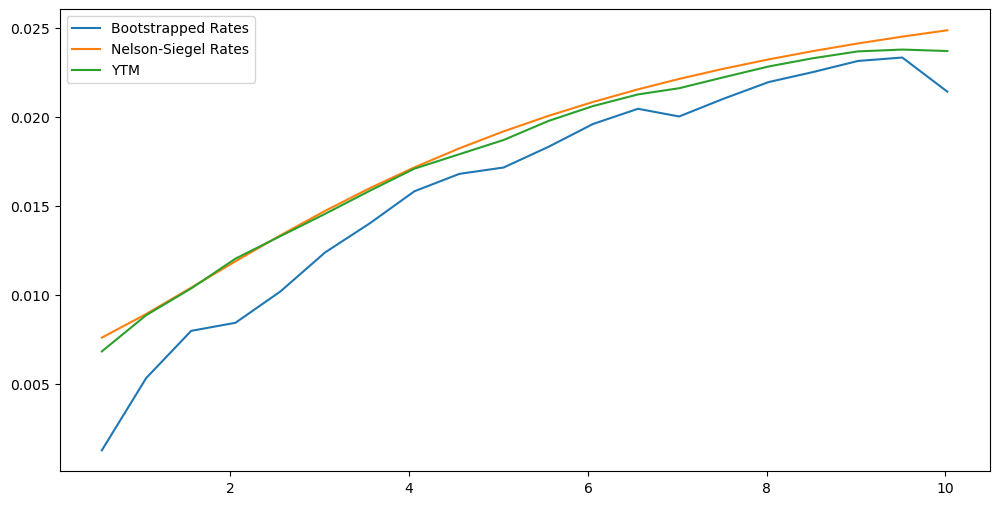

In [14]:
bootstrapped_rates = discount_dataframe["Spot_semianual_rate"].values
NS_rates = DF_ns["SemiAnual_Rate_NS"].values
YTM = select_maturities[ "ytm"].values
indexs = discount_dataframe.index

plt.figure(figsize=(12,6))
plt.plot(indexs, bootstrapped_rates, label="Bootstrapped Rates")
plt.plot(indexs, NS_rates, label="Nelson-Siegel Rates")
plt.plot(indexs, YTM, label="YTM")
plt.legend()


### 2.4 (10pts)

Which of the two spot rate curves (bootstrapped or Nelson-Siegel) would be better for...
* pricing the provided sample
* building spot rates out to 30 years
* calculating forward rates

For each of these three questions, be **specific** in your answer.

*Answer:*
- For pricing the provided sample, the boostrapped curve is better, because is there is only one bond per maturity, so the solution is unique.
- For 30y bonds, the Nelson-Siegel curve is better, because it is more flexible and can be used to interpolate.
- For calculating Fwd rates, the NS will generate smoother forward rate

### 2.5 (5pts)

Consider the bootstrapped curve and its associated forward curve. (No need to calculate the forward curve.)

Conceptually, do you expect it is higher or lower than the spot-rate curve at
* $T=1$
* $T=10$

Explain.


*Answer:*
- T = 1, because the spot rate is higher in T = 1 than T = 0.5, the fwd rate should be higher than the spot rate in T = 1.
- T = 10, because the spot rate is lower in T = 10 than T = 9.5, the fwd rate should be lower than the spot rate in T = 10.

### 2.6 (5pts)

Use the bootstrapped spot curve to calculate the forward rate for $T_1=3\to T_2=3.5$.

In [15]:
discount_dataframe["Fwd_discount_factor"] = discount_dataframe["Discount_factor_spot"]/discount_dataframe["Discount_factor_spot"].shift()
discount_dataframe["Fwd_discount_factor"].iloc[0] = discount_dataframe["Discount_factor_spot"].iloc[0]

discount_dataframe["Fwd_continuous_rate"] = -np.log(discount_dataframe["Fwd_discount_factor"]) / discount_dataframe.index.to_series().diff().mean()

C:\Users\josel\AppData\Local\Temp\ipykernel_30664\3905651878.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  discount_dataframe["Fwd_discount_factor"].iloc[0] = discount_dataframe["Discount_factor_spot"].iloc[0]


In [16]:
T2 = 3.5

# get index closest to value given Time-to-maturity are not exactly half years
idx = discount_dataframe.index[abs(discount_dataframe.index - T2).argmin()]

discount_dataframe.loc[idx, "Fwd_continuous_rate"]

0.0242188293647446

***

# 3. Trading the Yield Curve



Use the file, `famabliss_strips_2023-12-29.xlsx` for the following problem.

* The file provides prices for **strips** which are zero-coupon bonds. 
* Assume face value of 100.
* Because these prices are on zero-coupon bonds, they can be interpreted as discount factors, $Z$, directly.

Note that you will make use of only a few rows of the data set.

In [3]:
path = "../data/famabliss_strips_2023-12-29.xlsx"
strips = pd.read_excel(path, index_col=0)


In [4]:

def calculate_pnl(strips, date_range, key_long, key_short, initial_size):
    pnl_data = []  # Store PnL results
    contracts_data = []  # Store contract quantities (new short bond after rollover)
    position_data = []  # Store position values (new short bond after rollover)

    # Initialize first date
    t_date = date_range[0]
    
    # Initial prices
    price_long = strips.loc[t_date, key_long]
    price_short = strips.loc[t_date, key_short]

    # Initial quantities
    quantity_long = initial_size / price_long
    quantity_short = -((key_long * price_long) / (key_short * price_short)) * quantity_long

    # Initial positions
    position_long = quantity_long * price_long
    position_short = quantity_short * price_short

    # Store initial values
    pnl_data.append([t_date, 0, 0, 0])  # No PnL at t=0
    contracts_data.append([t_date, key_long, quantity_long, key_short, quantity_short])
    position_data.append([t_date, key_long, position_long, key_short, position_short])

    for i in range(1, len(date_range)):  
        t2_date = date_range[i]
        
        # Handle maturity of long bond
        if key_long - i < 1:  
            # Bond matures, receive face value
            price_long_new = 100  
        else:
            price_long_new = strips.loc[t2_date, key_long - i]  # Long position rolls down
        
        # Handle maturity of short bond (1-year bond pays face value)
        if key_short - 1 < 1:
            price_short_new = 100  # Face value at maturity
        else:
            price_short_new = strips.loc[t2_date, key_short - 1]  # Old short bond before roll

        # Update positions before rollover
        position_long_new = quantity_long * price_long_new
        position_short_new = quantity_short * price_short_new

        # Compute PnL
        pnl_long = position_long_new - position_long
        pnl_short = position_short_new - position_short
        net_pnl = pnl_long + pnl_short

        # Store PnL results
        pnl_data.append([t2_date, pnl_long, pnl_short, net_pnl])

        # Roll over short position (assign new short bond)
        if key_short - 1 < 1:
            # If the short bond has matured, there is no rollover
            quantity_short = 0
            position_short = 0
            new_key_short = None  # No new bond
        else:
            new_key_short = key_short  # New short bond is always a 1-year STRIP
            price_short_new_rolled = strips.loc[t2_date, new_key_short]  # New 1-year bond price
            quantity_short = -((key_long - i) * price_long_new) / (new_key_short * price_short_new_rolled) * quantity_long
            position_short = quantity_short * price_short_new_rolled

        # Store new contract and position values (reflecting new short bond after rollover)
        contracts_data.append([t2_date, key_long - i, quantity_long, new_key_short, quantity_short])
        position_data.append([t2_date, key_long - i, position_long_new, new_key_short, position_short])

        # Update positions
        position_long = position_long_new

    # Convert to DataFrames
    pnl_df = pd.DataFrame(pnl_data, columns=["Date", "Long PnL", "Short PnL", "Net PnL"]).set_index("Date")
    contracts_df = pd.DataFrame(contracts_data, columns=["Date", "Long Bond", "Long Contracts", "Short Bond", "Short Contracts"]).set_index("Date")
    position_df = pd.DataFrame(position_data, columns=["Date", "Long Bond", "Long Position", "Short Bond", "Short Position"]).set_index("Date")

    return pnl_df, contracts_df, position_df




# Example Usage:
# Example Usage:
path = "../data/famabliss_strips_2023-12-29.xlsx"
strips = pd.read_excel(path, index_col=0)

date_range = ["2010-01-29", "2011-01-31", "2012-01-31"]  # Adjust as needed
key_long = 5
key_short = 2
initial_size = 100e6

pnl_df, contracts_df, position_df = calculate_pnl(strips, date_range, key_long, key_short, initial_size)


display(pnl_df.style.format("{:,.2f}"))
display(contracts_df.style.format("{:,.2f}"))
display(position_df.style.format("{:,.2f}"))

,Long PnL,Short PnL,Net PnL
Date,,,
2010-01-29,0.00,0.00,0.00
2011-01-31,"6,179,199.31","-3,195,323.56","2,983,875.75"
2012-01-31,"5,284,231.55","-1,974,658.08","3,309,573.47"


,Long Bond,Long Contracts,Short Bond,Short Contracts
Date,,,,
2010-01-29,5.00,"1,124,880.49",2.00,"-2,539,847.73"
2011-01-31,4.00,"1,124,880.49",2.00,"-2,146,606.59"
2012-01-31,3.00,"1,124,880.49",2.00,"-1,679,421.11"


,Long Bond,Long Position,Short Bond,Short Position
Date,,,,
2010-01-29,5.00,"100,000,000.00",2.00,"-250,000,000.00"
2011-01-31,4.00,"106,179,199.31",2.00,"-212,358,398.62"
2012-01-31,3.00,"111,463,430.86",2.00,"-167,195,146.29"


In [6]:
strips[strips.index.isin(date_range)]

C:\Users\josel\AppData\Local\Temp\ipykernel_7840\3498289521.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  strips[strips.index.isin(date_range)]


,1,2,3,4,5
date,,,,,
2010-01-29,99.688332,98.431098,96.079773,92.897235,88.898332
2011-01-31,99.689175,98.927488,97.128458,94.391538,90.614294
2012-01-31,99.847386,99.555225,99.089131,98.067733,96.435549


In [12]:
import pandas as pd

def calculate_pnl(strips, date_range, key_long, key_short, initial_size, use_ratio = True):
    """
    Carry trade with:
      - Long an N=key_long-year STRIP from t=0 until it matures (rolling down in price each year).
      - Each year, short a key_short-year STRIP and close it exactly one year later 
        at its new price (because it has (key_short - 1) years left).
    
    If (key_short - 1) < 1 => the short matured => close at 100.
    Otherwise => close at strips.loc[new_date, key_short - 1].
    
    Then (if the long is still alive) re-open a brand-new key_short-year STRIP short 
    using the updated ratio:
        quantity_short = -((remaining_long_years * current_long_price)
                           / (key_short * current_short_price)) * quantity_long
    """
    
    pnl_data = []       # Store PnL results over time
    contracts_data = [] # Store contract quantities
    position_data = []  # Store position values
    
    # ------------------------------------------------
    # 1) INITIAL SETUP at the first date
    # ------------------------------------------------
    t_date = date_range[0]
    
    # (a) Get the initial long and short STRIP prices
    price_long_0  = strips.loc[t_date, key_long]        # key_long-year STRIP
    price_short_0 = strips.loc[t_date, key_short]       # key_short-year STRIP
    
    # (b) Long quantity
    quantity_long = initial_size / price_long_0
    
    # (c) Short quantity at t=0 (using your dynamic ratio for i=0 => 'remaining_long_years' = key_long)
    if use_ratio:
        quantity_short = -((key_long - 0) * price_long_0) / (key_short * price_short_0) * quantity_long
    else:
        quantity_short = -initial_size / price_short_0
    
    # (d) Position values in currency
    position_long  = quantity_long * price_long_0
    position_short = quantity_short * price_short_0
    
    # (e) Store the initial snapshots
    pnl_data.append([t_date, 0.0, 0.0, 0.0])
    contracts_data.append([t_date, key_long, quantity_long, key_short, quantity_short])
    position_data.append([t_date, key_long, position_long, key_short, position_short])
    
    # Track prior step’s position values for PnL calculations
    prev_long_val = position_long
    
    # For the *short side*, we need to remember how many years were left when we opened it
    # (initially it's key_short) so that after 1 year it is (key_short - 1).
    old_short_maturity = key_short
    old_short_price    = price_short_0
    old_short_qty      = quantity_short
    prev_short_val     = position_short

    # ------------------------------------------------
    # 2) LOOP OVER REMAINING DATES
    # ------------------------------------------------
    for i in range(1, len(date_range)):
        t2_date = date_range[i]
        
        # ~~~~~~~~~ LONG BOND: ROLL DOWN OR MATURE? ~~~~~~~~~
        remaining_long_years = key_long - i
        if remaining_long_years < 1:
            # The long bond matured => close at 100
            price_long_new = 100.0
        else:
            # The bond now is (key_long - i)-year strip
            price_long_new = strips.loc[t2_date, remaining_long_years]

        position_long_new = quantity_long * price_long_new
        pnl_long = position_long_new - prev_long_val
        
        # ~~~~~~~~~ SHORT BOND: CLOSE THE OLD ONE ~~~~~~~~~
        # Old short maturity after 1 year = (old_short_maturity - 1).
        new_short_mty_after_1y = old_short_maturity - 1
        
        # If that is < 1 => it matured => settle at 100.
        if new_short_mty_after_1y < 1:
            close_price = 100.0
        else:
            # Otherwise, it is still alive with (old_short_maturity - 1) years left
            close_price = strips.loc[t2_date, new_short_mty_after_1y]
        
        # Realized PnL from closing old short
        pnl_short_close = old_short_qty * (close_price - old_short_price)
        
        # ~~~~~~~~~ SHORT BOND: OPEN A NEW ONE (ROLL) ~~~~~~~~~
        # Only open new short if the long is still alive
        if remaining_long_years >= 1:
            # Price of the new key_short-year strip at t2_date
            new_short_price = strips.loc[t2_date, key_short]
            
            # Recompute the short quantity:
            # quantity_short = -((remaining_long_years * price_long_new)
            #                    / (key_short * new_short_price)) * quantity_long
            if use_ratio:
                new_short_qty = -((remaining_long_years) * price_long_new) / (key_short * new_short_price) * quantity_long
            else:
                new_short_qty = -initial_size / new_short_price

            
            position_short_new = new_short_qty * new_short_price
            
            # The new short maturity is always 'key_short'
            fresh_short_maturity = key_short
        else:
            # The long bond is done => no short position
            new_short_price      = 0.0
            new_short_qty        = 0.0
            position_short_new   = 0.0
            fresh_short_maturity = None
        
        # Short PnL for this step is just from closing the old short
        pnl_short = pnl_short_close
        
        # Net
        net_pnl = pnl_long + pnl_short
        
        # ~~~~~~~~~ STORE RESULTS ~~~~~~~~~
        pnl_data.append([t2_date, pnl_long, pnl_short, net_pnl])
        contracts_data.append([
            t2_date,
            max(remaining_long_years, 0), 
            quantity_long,
            fresh_short_maturity,
            new_short_qty
        ])
        position_data.append([
            t2_date,
            max(remaining_long_years, 0), 
            position_long_new,
            fresh_short_maturity,
            position_short_new
        ])
        
        # ~~~~~~~~~ UPDATE for next iteration ~~~~~~~~~
        prev_long_val  = position_long_new
        
        old_short_maturity = fresh_short_maturity if fresh_short_maturity is not None else 0
        old_short_price    = new_short_price
        old_short_qty      = new_short_qty
        prev_short_val     = position_short_new

    # ------------------------------------------------
    # 3) MAKE DATAFRAMES
    # ------------------------------------------------
    pnl_df = pd.DataFrame(
        pnl_data, 
        columns=["Date", "Long PnL", "Short PnL", "Net PnL"]
    ).set_index("Date")
    
    contracts_df = pd.DataFrame(
        contracts_data,
        columns=["Date", "Long Bond", "Long Qty", "Short Bond", "Short Qty"]
    ).set_index("Date")
    
    position_df = pd.DataFrame(
        position_data,
        columns=["Date", "Long Bond", "Long Position", "Short Bond", "Short Position"]
    ).set_index("Date")
    
    return pnl_df, contracts_df, position_df

# Example Usage
path = "../data/famabliss_strips_2023-12-29.xlsx"
strips = pd.read_excel(path, index_col=0)
strips = strips.loc['2018-12-01'::12]

# Suppose we pick 6 annual dates so that we hold the 5y bond from t=0 to t=5
date_range = strips.index
key_long = 5
key_short = 1
initial_size = 100e6

pnl_df, contracts_df, position_df = calculate_pnl(strips, date_range, key_long, key_short, initial_size, use_ratio=False)

display(pnl_df.style.format("{:,.2f}"))
display(contracts_df.style.format("{:,.2f}"))
display(position_df.style.format("{:,.2f}"))


,Long PnL,Short PnL,Net PnL
Date,,,
2018-12-31 00:00:00,0.00,0.00,0.00
2019-12-31 00:00:00,"6,021,315.23","-2,636,787.00","3,384,528.23"
2020-12-31 00:00:00,"6,751,760.77","-1,585,323.78","5,166,436.98"
2021-12-31 00:00:00,"-1,110,234.52","-104,244.84","-1,214,479.36"
2022-12-30 00:00:00,"-3,497,056.03","-384,148.40","-3,881,204.42"
2023-12-29 00:00:00,"5,139,989.08","-4,751,954.66","388,034.42"


,Long Bond,Long Qty,Short Bond,Short Qty
Date,,,,
2018-12-31 00:00:00,5.00,"1,133,057.75",1.00,"-1,026,367.87"
2019-12-31 00:00:00,4.00,"1,133,057.75",1.00,"-1,015,853.24"
2020-12-31 00:00:00,3.00,"1,133,057.75",1.00,"-1,001,042.45"
2021-12-31 00:00:00,2.00,"1,133,057.75",1.00,"-1,003,841.48"
2022-12-30 00:00:00,1.00,"1,133,057.75",1.00,"-1,047,519.55"
2023-12-29 00:00:00,0.00,"1,133,057.75",nan,0.00


,Long Bond,Long Position,Short Bond,Short Position
Date,,,,
2018-12-31 00:00:00,5.00,"100,000,000.00",1.00,"-100,000,000.00"
2019-12-31 00:00:00,4.00,"106,021,315.23",1.00,"-100,000,000.00"
2020-12-31 00:00:00,3.00,"112,773,076.00",1.00,"-100,000,000.00"
2021-12-31 00:00:00,2.00,"111,662,841.48",1.00,"-100,000,000.00"
2022-12-30 00:00:00,1.00,"108,165,785.45",1.00,"-100,000,000.00"
2023-12-29 00:00:00,0.00,"113,305,774.53",nan,0.00


,1,2,3,4,5
date,,,,,
2018-12-31,97.430953,95.195917,92.932725,90.580051,88.256755
2019-12-31,98.439417,96.893838,95.296407,93.570973,91.890972
2020-12-31,99.895864,99.751989,99.529858,98.945476,98.153653
2021-12-31,99.617322,98.550001,97.125082,95.487194,93.866839
2022-12-30,95.463612,91.622900,88.334676,85.104591,82.029785
2023-12-29,95.378749,91.964449,88.852295,85.667229,82.673963


### 1. (10pts)

Set up a trade as of `2010-01-29` to 
* go long 100 million (market value) of the 5-year.
* short the 2-year strips in a quantity that is duration hedged.

List the positions you hold long and short. 
* Assume you are financing the positions directly; no worries about haircuts. 
* Assume there are no market frictions, so you can short securities and immediately receive their market value. 
* (No need to worry about borrowing costs for the short.)

In [18]:
t_date = "2010-01-29"
long_position = 100e6
key_long = 5
key_short = 2
price_long = strips.loc[t_date, key_long]
price_short = strips.loc[t_date, key_short]

quantity_long = long_position / price_long
quantity_short = -((5*price_long)/(2*price_short)) * quantity_long

position_long = quantity_long * price_long
position_short = quantity_short * price_short

summary = pd.DataFrame(index=[key_long, key_short], columns=["Price", "Contracts", "Position"], dtype=float)
summary.loc[key_long] = [price_long, quantity_long, position_long]
summary.loc[key_short] = [price_short, quantity_short, position_short]
summary.loc["Net", "Position"] = position_long + position_short

display(summary.style.format("{:,.2f}"))

,Price,Contracts,Position
5,88.90,"1,124,880.49","100,000,000.00"
2,98.43,"-2,539,847.73","-250,000,000.00"
Net,nan,nan,"-150,000,000.00"


### 2. (5pts)
As of `2011-01-31`, assess the pnl on the long, short, and net trade.

In [19]:
t2_date = "2011-01-31"

price_long = strips.loc[t2_date, key_long-1]
price_short = strips.loc[t2_date, key_short-1]

position_long = quantity_long * price_long
position_short = quantity_short * price_short

summary.loc[key_long, "New Price"] = price_long
summary.loc[key_short, "New Price"] = price_short
summary.loc[key_long, "New Position"] = position_long
summary.loc[key_short, "New Position"] = position_short
summary.loc["Net", "New Position"] = position_long + position_short

summary["PnL"] = summary["New Position"] - summary["Position"]

display(summary.style.format("{:,.2f}"))

PnL = summary.loc["Net", "PnL"]

,Price,Contracts,Position,New Price,New Position,PnL
5,88.90,"1,124,880.49","100,000,000.00",94.39,"106,179,199.31","6,179,199.31"
2,98.43,"-2,539,847.73","-250,000,000.00",99.69,"-253,195,323.56","-3,195,323.56"
Net,nan,nan,"-150,000,000.00",nan,"-147,016,124.25","2,983,875.75"


### 3. (10pts)
On `2011-01-31`, roll over the trade.
* close out the short positions
* enter new short positions in 2-year strips that are a duration hedge against your (continuing) long positions.

List the details of your short and long positions in terms of market value and face value of each side of the trade.

In [20]:
PnL_2y = summary.loc[key_short, "PnL"]

price_short = strips.loc[t2_date, key_short]
price_long = strips.loc[t2_date, key_long-1]

quantity_long = summary.loc[key_long, "Contracts"]
quantity_short = -(((key_long-1)*price_long)/(key_short*price_short)) * quantity_long

position_long = quantity_long * price_long
position_short = quantity_short * price_short


summary2 = pd.DataFrame(index=[key_long-1, key_short], columns=["Price", "Contracts", "Position"], dtype=float)
summary2.loc[key_long-1] = [price_long, quantity_long, position_long]
summary2.loc[key_short] = [price_short, quantity_short, position_short]
summary2.loc["Net", "Position"] = position_long + position_short 

display(summary2.style.format("{:,.2f}"))



,Price,Contracts,Position
4,94.39,"1,124,880.49","106,179,199.31"
2,98.93,"-2,146,606.59","-212,358,398.62"
Net,nan,nan,"-106,179,199.31"


### 4. (5pts)
On `2012-01-31`, close out the trade.

Report...
* pnl for the long, short, and net of the trade.

In [21]:
t3_date = "2012-01-31"

price_long = strips.loc[t3_date, key_long-2]
price_short = strips.loc[t3_date, key_short-1]

position_long = quantity_long * price_long
position_short = quantity_short * price_short

summary2.loc[key_long-1, "New Price"] = price_long
summary2.loc[key_short, "New Price"] = price_short
summary2.loc[key_long-1, "New Position"] = position_long
summary2.loc[key_short, "New Position"] = position_short
summary2.loc["Net", "New Position"] = position_long + position_short

summary2["PnL"] = summary2["New Position"] - summary2["Position"]

display(summary2.style.format("{:,.2f}"))


,Price,Contracts,Position,New Price,New Position,PnL
4,94.39,"1,124,880.49","106,179,199.31",99.09,"111,463,430.86","5,284,231.55"
2,98.93,"-2,146,606.59","-212,358,398.62",99.85,"-214,333,056.70","-1,974,658.08"
Net,nan,nan,"-106,179,199.31",nan,"-102,869,625.84","3,309,573.47"


In [22]:
acumulated_pnl = pd.concat([summary["PnL"], summary2["PnL"]], axis=1)
acumulated_pnl.columns = ["PnL_1y", "PnL_2y"]
acumulated_pnl.loc[5, "PnL_2y"] = acumulated_pnl.loc[4, "PnL_2y"]
acumulated_pnl.drop(4, inplace=True)
acumulated_pnl["Cumulative PnL"] = acumulated_pnl.sum(axis=1)
display(acumulated_pnl.style.format("{:,.2f}"))

,PnL_1y,PnL_2y,Cumulative PnL
5,"6,179,199.31","5,284,231.55","11,463,430.86"
2,"-3,195,323.56","-1,974,658.08","-5,169,981.64"
Net,"2,983,875.75","3,309,573.47","6,293,449.22"


### 5. (5pts)
How did this trade do compared to a long-only trade in 5-year notes? Explain.

*Answer:* The trade made it worst than only holding the 5-year STRIPS. While the 5-year STRIPS had a positive PnL, the 2-year STRIPS rolling position had a negative PnL.

### 6. (5pts)

Notwithstanding the duration hedge, why was the trade still sensitive to changing levels of the spot rate curve?

Be specific in your answer, and consider which quantitative metric would support your answer.

*Answer:* While we are hedging the position for the duration (which is the sentivity to a parallel shift of the curve), the long-short trade has a positive convexity, this means that the change on the curvature also impact to the resulting PnL

### 7. (5pts)

Does this trade rely on the Expectations Hypothesis being true or false? How about this type of trade in general?

*Answer :* This type of trades don't depend on the EH, because these trades rely on the carry trade, that means on average there is a positive return in holding the higher yield security. And the EH said the long term rates are on average, the short term rates, not for a specific period

### 8. (5pts)

As of `2012-01-31`, is the market environment favorable to this type of long-short trade?

Be specific.

<Axes: >

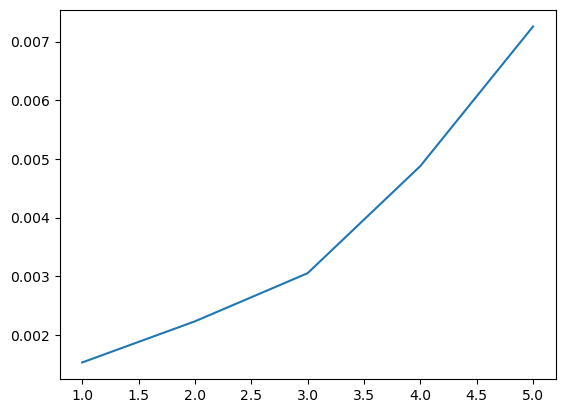

In [23]:
implied_rates = -np.log(strips/100)/strips.columns
implied_rates.loc["2012-01-31"].plot()

*Answer :* Even when the curve has an upward slope, it's almost flat, according to EH is not favorable for these type of trades

### 9. (5pts)

As of `2010-01-29`, what is the continuously compounded forward rate from $T_1=2\to T_2=4$?

In [24]:
strips_transposed = strips.T/100
fwd_discount = strips_transposed.loc[4, "2010-01-29"]/strips_transposed.loc[2, "2010-01-29"]
fwd_rate = -np.log(fwd_discount)/2
print(f"The forward rate from 2 to 4 years is: {fwd_rate:.4%}")

The forward rate from 2 to 4 years is: 2.8931%


In [25]:
fwd_discount = strips_transposed/strips_transposed.shift(2)
fwd_discount.iloc[1] = strips_transposed.iloc[1]
fwd_rate = -np.log(fwd_discount)/2

In [26]:
fwd_rate[["2010-01-29", "2011-01-31", "2012-01-31"]].T.style.format("{:.2%}")

,1,2,3,4,5
date,,,,,
2010-01-29 00:00:00,nan%,0.79%,1.84%,2.89%,3.88%
2011-01-31 00:00:00,nan%,0.54%,1.30%,2.35%,3.47%
2012-01-31 00:00:00,nan%,0.22%,0.38%,0.75%,1.36%


### 10. (5pts)

As of `2012-01-31`, is the two-year continuously-compoounded spot rate, $r(0,2)$ higher or lower than the forward rate calculated above for `2010-01-29`?

Is this surprising?

***

# 4. The Swap-Spread

Consider the market data below. 
* It refers to **20-year** T-bonds and swaps.
* Assume the T-bond has exactly 20-years to maturity, with a coupon that exactly matches the YTM below.

In [27]:
summary = pd.DataFrame(index=['YTM','swap rate'],columns = ['Nov 2018','Nov 2023'],dtype=float)
summary.loc['YTM'] = [.031480, .046670]
summary.loc['swap rate'] = [.027639,.039895]
summary.style.format('{:.4%}')

,Nov 2018,Nov 2023
YTM,3.1480%,4.6670%
swap rate,2.7639%,3.9895%


### 4.1. (5pts)

Consider `Nov 2018`. Suppose you enter into a swap-spread trade.
* You go long \$100 million **market value** of 20-year T-bonds.
* You simultaneously enter a 20-year swap, paying-fixed, with notional of \$100 million.


Report the 
* price of the T-bond in Nov 2018.
* amount of T-bonds purchased, (each face value of 100).

In [28]:
long_position = 100e6

duration_t_bond = hf.duration_closed_formula(tau = 20, ytm = summary.loc['YTM', "Nov 2018"] , cpnrate=summary.loc['YTM', "Nov 2018"] , freq=2)
duration_swap = hf.duration_closed_formula(tau = 20, ytm = summary.loc['swap rate', "Nov 2018"] , cpnrate=summary.loc['swap rate', "Nov 2018"] , freq=2)

# hedge_ratio = -duration_t_bond / duration_swap
hedge_ratio = -1
short_position = long_position * hedge_ratio

contract_t_bond = long_position / 100
contract_swap = short_position / 100

summary2 = pd.DataFrame(index=['T-Bond','Swap'],columns = ['Duration','Hedge Ratio','Position','Contracts'],dtype=float)
summary2.loc['T-Bond'] = [duration_t_bond, 1, long_position, contract_t_bond]
summary2.loc['Swap'] = [duration_swap, hedge_ratio, short_position, contract_swap]
summary2.style.format({'Duration':'{:.4f}','Hedge Ratio':'{:.4f}','Position':'{:,.2f}','Contracts':'{:,.2f}'})


,Duration,Hedge Ratio,Position,Contracts
T-Bond,14.9901,1.0000,"100,000,000.00","1,000,000.00"
Swap,15.4965,-1.0000,"-100,000,000.00","-1,000,000.00"


### 4.2. (5pts)

Report the first cashflow of the trade, in May 2019.

For simplicity, 
* assume the swap pays semiannually, at the same date the T-bond pays coupons.
* the repo rate involved in the trade cancels out with the floating rate of the swap.
* the repo term is semiannually, corresponding to the coupon and swap dates.
* there are not any margin calls or distributions in the discussion below.

If the haircut is 4\% to repo the T-bonds, then what is the May 2019 cashflow as a percentage of the equity capital in the position?

In [29]:
haircut = 0.04

coupon_t_bond = summary.loc['YTM', "Nov 2018"]/2
coupon_swap = summary.loc['swap rate', "Nov 2018"]/2

summary2.loc["T-Bond", "Coupon_CF"] = coupon_t_bond*summary2.loc["T-Bond", "Position"]
summary2.loc["Swap", "Coupon_CF"] = coupon_swap*summary2.loc["Swap", "Position"]
summary2.loc["Net", "Coupon_CF"] = summary2.loc["T-Bond", "Coupon_CF"] + summary2.loc["Swap", "Coupon_CF"]
summary2.loc["Net", "Return"] = summary2.loc["Net", "Coupon_CF"]/(haircut*long_position)

summary2.style.format({'Duration':'{:.4f}','Hedge Ratio':'{:.4f}','Position':'{:,.2f}','Contracts':'{:,.2f}','Coupon_CF':'{:,.2f}','Return':'{:.2%}'})

,Duration,Hedge Ratio,Position,Contracts,Coupon_CF,Return
T-Bond,14.9901,1.0000,"100,000,000.00","1,000,000.00","1,574,000.00",nan%
Swap,15.4965,-1.0000,"-100,000,000.00","-1,000,000.00","-1,381,950.00",nan%
Net,nan,nan,nan,nan,"192,050.00",4.80%


### 4.3. (5pts)

Report the risk of the trade.
* Duration and dollar duration for the T-bond
* Duration and dollar duration for the swap

Note that you are reporting the usual, Macauley, duration--not the modified duration. 

For each of these duration calculations, use only the YTM and swap rates--no need for a discount curve.

In [30]:
summary2["Duration"]

T-Bond    14.990104
Swap      15.496528
Net             NaN
Name: Duration, dtype: float64

### 4.4. (5pts)

Use **modified** duration to answer the following:

* What is the expected profit and loss if the swap-spread goes to zero?
* What return would this be relative to the initial equity capital to put on the position?

#### Note:
We refer to the spread (swap-rate minus T-bond YTM) going to zero symmetrically (the YTM falls and swap rate rise equally until converging.)

In [36]:
summary2.loc["T-Bond", "YTM"] = summary.loc['YTM', "Nov 2018"]
summary2.loc["Swap", "YTM"] = summary.loc['swap rate', "Nov 2018"]

summary2.loc["T-Bond", "Modified Duration"] = summary2.loc["T-Bond", "Duration"] / (1 + summary2.loc["T-Bond", "YTM"]/2)
summary2.loc["Swap", "Modified Duration"] = summary2.loc["Swap", "Duration"] / (1 + summary2.loc["Swap", "YTM"]/2)

swap_spread = summary.loc['swap rate', "Nov 2018"] - summary.loc['YTM', "Nov 2018"] 

summary2.loc["Swap", "Delta rate"] = swap_spread/2
summary2.loc["T-Bond", "Delta rate"] = -swap_spread/2

summary2["Change in Dirty Price"] = summary2["Modified Duration"] * summary2["Delta rate"] * 100 *  summary2["Contracts"]
summary2.loc["Net", "Change in Dirty Price"] = summary2["Change in Dirty Price"].sum()
summary2.loc["Net", "Return price"] = summary2.loc["Net", "Change in Dirty Price"]/(haircut*long_position)

In [35]:
swap_spread*100

-0.38410000000000005

In [37]:
summary2

,Duration,Hedge Ratio,Position,Contracts,Coupon_CF,Return,YTM,Modified Duration,Delta rate,Change in Dirty Price,Return price
T-Bond,14.990104,1.0,100000000.0,1000000.0,1574000.0,NaN,0.031480,14.757816,0.001921,2.834239e+06,NaN
Swap,15.496528,-1.0,-100000000.0,-1000000.0,-1381950.0,NaN,0.027639,15.285293,-0.001921,2.935541e+06,NaN
Net,NaN,NaN,NaN,NaN,192050.0,0.048012,NaN,NaN,NaN,5.769779e+06,1.442445


### 4.5. (10pts)

Now it is `Nov 2023`. Use the market quotes to report...
* the value of the long T-bond positions (15 years-to-maturity)
* the value of the paying-fixed swap (15 years-to-expiration)
* the net value of your position and return on your equity capital.

In [82]:
summary

,Nov 2018,Nov 2023
YTM,0.031480,0.046670
swap rate,0.027639,0.039895


In [38]:
delta_t_bond_price = hf.price_treasury_ytm(time_to_maturity = 15, ytm = summary.loc["YTM", "Nov 2023"], cpn_rate = summary.loc["YTM", "Nov 2018"] ,freq=2,face=100) -100
delta_swap_price = hf.price_treasury_ytm(time_to_maturity = 15, ytm = summary.loc["swap rate", "Nov 2023"], cpn_rate = summary.loc["swap rate", "Nov 2018"] ,freq=2,face=100) -100

summary2.loc["T-Bond", "Delta Price"] = delta_t_bond_price
summary2.loc["Swap", "Delta Price"] = delta_swap_price
summary2["Position Value"] =  summary2[ "Contracts"] * summary2["Delta Price"]
summary2.loc["Net", "Position Value"] = summary2["Position Value"].sum()

summary2.loc["T-Bond", "Coupon Payment"] = coupon_t_bond*5*2
summary2.loc["Swap", "Coupon Payment"] = coupon_swap*5*2
summary2["Coupon Value"] = summary2["Coupon Payment"]*summary2["Position"]
summary2.loc["Net", "Coupon Value"] = summary2["Coupon Value"].sum()

summary2["PnL"] = summary2["Position Value"] + summary2["Coupon Value"]

summary2[["Contracts","Delta Price",'Position Value',"Coupon Payment",'Coupon Value','PnL']].style.format("{:,.2f}")

,Contracts,Delta Price,Position Value,Coupon Payment,Coupon Value,PnL
T-Bond,"1,000,000.00",-16.26,"-16,255,272.67",0.16,"15,740,000.00","-515,272.67"
Swap,"-1,000,000.00",-13.73,"13,734,460.62",0.14,"-13,819,500.00","-85,039.38"
Net,nan,nan,"-2,520,812.04",nan,"1,920,500.00","-600,312.04"


### 4.6. (5pts)

Assume there are no market frictions, and there is more credit risk in the swap than in the T-bond.

In that case, is the swap-spread trade an arbitrage, a statistically favorable trade, both, or neither? 

Be specific whether your answer is for the long-term or short-term.

* Long-term: There is not risk involved, giving the YTM is going to generate profit if we hold until maturity

* Short-term: statistical trade, depend on the spread evolving, we are shorting the swap spread

***